## 2. Grouping customers together!

### 2.1 Getting your data + feature engineering

In [1]:
import pandas as pd
from datetime import datetime 
from scipy import stats
import numpy as np

In [2]:
df = pd.read_csv('archive.zip') #reading the file 

In [3]:
df.dropna(inplace = True) #dropping Nan values 

In [4]:
#converting timestamps object in datetime objects 
df.CustomerDOB = pd.to_datetime(df.CustomerDOB)
df.TransactionDate = pd.to_datetime(df.TransactionDate)
df.TransactionTime = df.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

Replace (Date of Birth == 1800) and (Date of Birth > 2010) with _NaN_ in order to not lose the other information

In [5]:
df["CustomerDOB"] = df["CustomerDOB"].dt.year.replace(1800, np.NaN).astype("datetime64[ns]")
df["CustomerDOB"] = df["CustomerDOB"].dt.year.replace(r"201\d+", np.NaN).astype("datetime64[ns]")

#### 2.1.2

In [6]:
# a) Number of transactions
nt = df.groupby('CustomerID').count().TransactionID.reset_index(name='NumTransactions')
new_feature = pd.DataFrame(nt)

In [7]:
# b) Number of transactions with a balance bigger than 100 USD
df.rename(columns = {'TransactionAmount (INR)':'TransactionAmount'}, inplace = True)
ntbb = df[df.TransactionAmount > 100].groupby('CustomerID').count().TransactionID.reset_index(name='Ntbb')
new_feature = pd.merge(new_feature, ntbb, on = ['CustomerID', 'CustomerID'])

In [8]:
# c) Average amount of the transactions
aat = df.groupby('CustomerID').mean().TransactionAmount.reset_index(name='AveAmTransactions')
new_feature = pd.merge(new_feature, aat, on = ['CustomerID', 'CustomerID'])

In [9]:
# d) Average balance
ab = df.groupby('CustomerID').mean().CustAccountBalance.reset_index(name='Average Balance')
new_feature = pd.merge(new_feature, ab, on = ['CustomerID', 'CustomerID'])

In [10]:
# e) Average difference between the balance and the transaction amount for each customer
df['utilisation'] = df['CustAccountBalance'] - df['TransactionAmount'] #Utilisations negative
ut = df.groupby('CustomerID').mean().utilisation.reset_index(name='Utilisation')
new_feature = pd.merge(new_feature, ut, on = ['CustomerID', 'CustomerID'])

In [11]:
# f) Most common gender of the customer
mcg = df.groupby('CustomerID')['CustGender'].agg(lambda x: stats.mode(x)[0][0]).reset_index(name='MostCommonGender')
new_feature = pd.merge(new_feature, mcg, on = ['CustomerID', 'CustomerID'])

In [12]:
# h) Most frequent location of the customer 
mfl = df.groupby('CustomerID')['CustLocation'].agg(lambda x: stats.mode(x)[0][0]).reset_index(name='MostFreqLocation')
new_feature = pd.merge(new_feature, mfl, on = ['CustomerID', 'CustomerID'])

#### 2.1.3

Our features:
1. Average age
2. Number of users
3. Quantiles over the account balance
4. Presence of transactions over 50'000
5. Transaction amount variance
6. Quantiles over the average transaction amount
7. Number of different places
8. Filter if the account has a transaction in the top 25 most frequent places
9. Presence of minors in the account
10. Mean hour for each customer
11. Most common hour for each customer
12. Number of women
13. Number of men
14. Max purchase
15. Min purchase
16. Avearage Transaction / Balance (%)
17. Min Balance
18. Max Balance
19. Presence of recurring transactions (same tr. amount)
20. Transaction Distance (in days)

In [13]:
# 1) Average age of CustomerID
df['CustAge'] = round(((df.TransactionDate - df.CustomerDOB) / np.timedelta64(1, 'Y')), 0)
average = df.groupby('CustomerID').mean().CustAge.reset_index(name='AverageAge')
new_feature = pd.merge(new_feature, average, on = ['CustomerID', 'CustomerID'])

In [14]:
# 2) Number of users per CustomerID
nu = df.groupby('CustomerID')['CustomerID'].count().reset_index(name='UsersPerCustomerID')
new_feature = pd.merge(new_feature, nu, on = ['CustomerID', 'CustomerID'])

In [15]:
# 3) Quantiles over the account balance distribution
q = list(df["CustAccountBalance"].quantile([0,.25,.50,.75,.95]))
new_feature["BalanceQuant"] = df.apply(lambda x: .95 if x.CustAccountBalance >= q[4] else .75 if x.CustAccountBalance >= q[3]\
                                     else .50 if x.CustAccountBalance >= q[2] else .25 if x.CustAccountBalance >= q[1] else 0, axis=1)

In [16]:
# 4) Presence of transactions over 50'000
new_feature["TrOver50k"]=df["CustomerID"].isin(df[df["TransactionAmount"]>=50000].CustomerID)

In [17]:
# 5) Transaction amount variance
tav = df.groupby('CustomerID').var().TransactionAmount.reset_index(name='VarAmTransactions')
new_feature = pd.merge(new_feature, tav, on = ['CustomerID', 'CustomerID'])

In [18]:
# 6) Quantiles over the average transaction amount
q = list(new_feature["AveAmTransactions"].quantile([0,.25,.50,.75,.95]))
new_feature["AveTrQuant"] = new_feature.apply(lambda x: .95 if x.AveAmTransactions >= q[4] else .75 if x.AveAmTransactions >= q[3]\
                                     else .50 if x.AveAmTransactions >= q[2] else .25 if x.AveAmTransactions >= q[1] else 0, axis=1)

In [19]:
# 7) Number of different places
diff = df.groupby("CustomerID").CustLocation.count().reset_index(name='DifferentLocations')
new_feature = pd.merge(new_feature, diff, on = ['CustomerID', 'CustomerID'])

In [20]:
# 8) Filter if the account has a transaction in the top 25 most frequent places
places = df.groupby("CustLocation").CustomerID.count().sort_values(ascending=False)
top_places = places.head(int(len(places)*0.25))
has_tx = df[df.apply(lambda x: x.CustLocation in top_places.index, axis=1)].CustomerID.unique()
new_feature["TopPlaces"] = df["CustomerID"].isin(has_tx)

In [21]:
# 9) Presence of minors in the account
new_feature["WithChildren"]=df["CustomerID"].isin(df[df["CustAge"]<18].CustomerID)

In [22]:
# 10) Mean hour for each customer
mh = df.groupby("CustomerID").TransactionTime.mean().apply(lambda x: x.hour).reset_index(name='MeanHour')
new_feature = pd.merge(new_feature, mh, on = ['CustomerID', 'CustomerID']) 

In [23]:
# 11) Most common hour for each customer
df["TrHour"] = df.apply(lambda x: x.TransactionTime.hour,axis=1)
moh = df.groupby("CustomerID").TrHour.agg(lambda x: pd.Series.mode(x).iloc[0]).reset_index(name='MostCommonHour')
new_feature = pd.merge(new_feature, moh, on = ['CustomerID', 'CustomerID']) 

In [24]:
# 12) Number of women
wn = df[df["CustGender"]=="F"].groupby("CustomerID").CustomerDOB.count().reset_index(name='NumOfWomen')
new_feature = pd.merge(new_feature, wn, on = ['CustomerID', 'CustomerID']) 

In [25]:
# 13) Number of men
mn = df[df["CustGender"]=="M"].groupby("CustomerID").CustomerDOB.count().reset_index(name='NumOfMen')
new_feature = pd.merge(new_feature, mn, on = ['CustomerID', 'CustomerID']) 

In [26]:
# 14) Max purchase
mxp =  df.groupby('CustomerID').TransactionAmount.max().reset_index(name='MaxTransaction')
new_feature = pd.merge(new_feature, mxp, on = ['CustomerID', 'CustomerID'])

In [27]:
# 15) Min purchase
mnp =  df.groupby('CustomerID').TransactionAmount.min().reset_index(name='MinTransaction')
new_feature = pd.merge(new_feature, mnp, on = ['CustomerID', 'CustomerID'])

In [28]:
# 16) Transaction / Balance (%)
df['TransactionBalance'] = (df['TransactionAmount'] * 100) / (df['CustAccountBalance']+df['TransactionAmount'])
atb =  df.groupby('CustomerID').TransactionBalance.mean().reset_index(name='Ave_Transaction/Balance')
new_feature = pd.merge(new_feature, atb, on = ['CustomerID', 'CustomerID'])

In [29]:
# 17) Min Balance
mnp =  df.groupby('CustomerID').CustAccountBalance.min().reset_index(name='MinBalance')
new_feature = pd.merge(new_feature, mnp, on = ['CustomerID', 'CustomerID'])

In [30]:
# 18) Max Balance
mnp =  df.groupby('CustomerID').CustAccountBalance.max().reset_index(name='MaxBalance')
new_feature = pd.merge(new_feature, mnp, on = ['CustomerID', 'CustomerID'])

In [31]:
# 19) Presence of recurring transactions
rec = df.groupby(["CustomerID","TransactionAmount"]).TransactionID.count().groupby("CustomerID").max().reset_index(name='RecurringTr')
new_feature = pd.merge(new_feature, rec, on = ['CustomerID', 'CustomerID'])

In [32]:
# 20) Transaction Distance (in days)
dif = df.sort_values(['CustomerID','TransactionDate'])\
           .groupby('CustomerID')['TransactionDate']\
           .diff().dt.days.fillna(0).rename("TrDayDiff")

new_feature.sort_values("CustomerID",inplace=True)
new_feature["TrDayDiff"] = dif

The result is a DataFrame with 27 features:

In [33]:
new_feature.columns

Index(['CustomerID', 'NumTransactions', 'Ntbb', 'AveAmTransactions',
       'Average Balance', 'Utilisation', 'MostCommonGender',
       'MostFreqLocation', 'AverageAge', 'UsersPerCustomerID', 'BalanceQuant',
       'TrOver50k', 'VarAmTransactions', 'AveTrQuant', 'DifferentLocations',
       'TopPlaces', 'WithChildren', 'MeanHour', 'MostCommonHour', 'NumOfWomen',
       'NumOfMen', 'MaxTransaction', 'MinTransaction',
       'Ave_Transaction/Balance', 'MinBalance', 'MaxBalance', 'RecurringTr',
       'TrDayDiff'],
      dtype='object')

# 2.2

In [34]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

### 2.1 Preprocessing
Encoding categorical features:
```python
"""Save the mapping array"""
#enc = preprocessing.LabelEncoder()
np.save('array.npy', enc.classes_) # to save the mapping
enc.classes_ = np.load('array.npy') # for reuse
```

In [35]:
features = ["MostFreqLocation","MostCommonGender","TrOver50k","TopPlaces","WithChildren"]  # all non-numeric features
for f in features:
    enc = preprocessing.LabelEncoder()
    enc.fit(new_feature[f])
    new_feature[f] = enc.transform(new_feature[f])
    np.save("./map/"+f+'.npy', enc.classes_)

Scaling to [0,1]

In [41]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(new_feature.dropna().drop("CustomerID",axis=1))

### 2.2 PCA

In [ ]:
new_feature.dropna().drop("CustomerID",axis=1)

In [45]:
pca = PCA(n_components=2)
red_data = pca.fit_transform(scaled)
print("Variance:",sum(pca.explained_variance_ratio_))

Variance: 0.3713217293993575


$\longrightarrow$ _In the scaled version the variance is too low_

In [46]:
pca = PCA(n_components=2)
red_data = pca.fit_transform(new_feature.dropna().drop("CustomerID",axis=1))
print("Variance:",sum(pca.explained_variance_ratio_))

Variance: 0.9999999629750561


In [52]:
#np.save('reduced_data.npy', red_data)

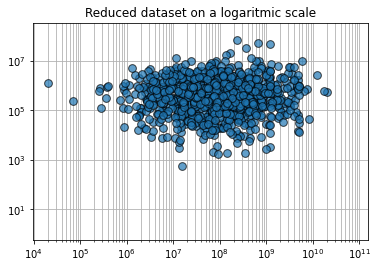

In [47]:
fig, ax = plt.subplots()
plt.grid(True,zorder=0, which="both", ls="-")
ax.scatter(red_data[:,0],red_data[:,1], s=60, alpha=0.7, edgecolors="k",zorder=3)
plt.title("Reduced dataset on a logaritmic scale")
ax.set_yscale("log")
ax.set_xscale("log")